<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/LSTM_Attention_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [1]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 22.7 MB/s 
     |████████████████████████████████| 81 kB 3.2 MB/s 
     |████████████████████████████████| 210 kB 74.4 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 147 kB 79.0 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 112 kB 68.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=2933907828926ba14847476947d2e05b77458b665aca2691d7a55388e36f125e
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unins

In [2]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [4]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [5]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [6]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [7]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [8]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [9]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [11]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [12]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [13]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [14]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [15]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

attention mechanism

In [18]:
#attention mechnism code

class TemporalAttn(nn.Module):
    def __init__(self, hidden_size):
        super(TemporalAttn, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc2 = nn.Linear(self.hidden_size*2, self.hidden_size, bias=False)

    def forward(self, hidden_states):
        # (batch_size, time_steps, hidden_size)
        score_first_part = self.fc1(hidden_states)
        
        # (batch_size, hidden_size)
        h_t = hidden_states[:,-1,:]
        
        # (batch_size, time_steps)
        score = torch.bmm(score_first_part, h_t.unsqueeze(2)).squeeze(2)
        attention_weights = F.softmax(score, dim=1)
        
        # (batch_size, hidden_size)
        context_vector = torch.bmm(hidden_states.permute(0,2,1), attention_weights.unsqueeze(2)).squeeze(2)

        # (batch_size, hidden_size*2)
        pre_activation = torch.cat((context_vector, h_t), dim=1)
        
        # (batch_size, hidden_size)
        attention_vector = self.fc2(pre_activation)
        attention_vector = torch.tanh(attention_vector)

        return attention_vector, attention_weights


In [19]:
class LSTMATT(nn.Module):
    def __init__(self, input_dim, timesteps, output_dim, hidden_size=32):
        super().__init__()
        
        self.lstm = nn.LSTM(input_dim, output_dim, batch_first=True)                     #LSTM layer
        
        self.linear1 = nn.Linear(output_dim, output_dim)                                #Linear layer
                
        self.attn = TemporalAttn(hidden_size=output_dim)                                #attention mechanism

    def forward(self, x):
        y1, (_, _) = self.lstm(x)        
        out, weights = self.attn(y1)
        out = self.linear1(out)
        return out

In [20]:
#checking dimensions of the GRU layers

#x = torch.rand(64, 120, 9)
#model = LSTMATT(input_dim = 9, 
#            hidden_size=64,
#            output_dim=24, 
#            timesteps=5*24)

#y = model(x)
#y.shape

In [21]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    
    # Generate the model.
    model = LSTMATT(input_dim = 9, 
                    hidden_size=trial.suggest_int("hidden_dim2", 16, 128),
                    output_dim=24, 
                    timesteps=5*24).cuda()
                    #hidden_size2 = trial.suggest_int("hidden_dim2", 16, 128),    

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "LSTMATT_BO.pt")

        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
    return min_val_loss

In [22]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=40)  

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-23 23:59:04,071] A new study created in memory with name: no-name-dce1f473-7734-47a1-8574-075e0f30044d


Iter:  0 train:  3996.1120944023132 val:  532.7567434310913
Iter:  20 train:  203.0174553990364 val:  57.70611261576414
Iter:  40 train:  138.93874867260456 val:  38.24665319919586
Iter:  60 train:  107.52093575149775 val:  31.963352248072624
Iter:  80 train:  96.7668751552701 val:  30.341461077332497
Iter:  100 train:  90.74756857007742 val:  28.93374464288354
Iter:  120 train:  86.73101888597012 val:  28.17174598760903
Iter:  140 train:  83.72265852987766 val:  27.953887183219194
Iter:  160 train:  81.15977337956429 val:  27.721357099711895
Iter:  180 train:  79.0076504945755 val:  26.6097401548177
Iter:  200 train:  77.24708566069603 val:  27.3432434797287


[I 2022-12-24 00:08:41,956] Trial 0 finished with value: 26.178577661514282 and parameters: {'hidden_dim2': 39, 'lr': 2.2829821349470392e-05}. Best is trial 0 with value: 26.178577661514282.


Iter:  0 train:  597.9431623965502 val:  46.14429245889187
Iter:  20 train:  65.63643436133862 val:  24.36543593555689
Iter:  40 train:  57.86685470864177 val:  24.843493254855275
Iter:  60 train:  52.072340466082096 val:  25.454845255240798


[I 2022-12-24 00:12:00,890] Trial 1 finished with value: 23.21671581082046 and parameters: {'hidden_dim2': 65, 'lr': 0.0007588267509674761}. Best is trial 1 with value: 23.21671581082046.


Iter:  0 train:  1998.107870221138 val:  229.0105088353157
Iter:  20 train:  87.23369097709656 val:  29.319931734353304
Iter:  40 train:  72.56253351271152 val:  26.54288229905069
Iter:  60 train:  67.19221226498485 val:  25.26533704251051
Iter:  80 train:  64.36657329648733 val:  25.598761212080717
Iter:  100 train:  62.132396534085274 val:  24.177331348881125


[I 2022-12-24 00:16:59,237] Trial 2 finished with value: 23.95959277264774 and parameters: {'hidden_dim2': 55, 'lr': 0.00013586701764766793}. Best is trial 1 with value: 23.21671581082046.


Iter:  0 train:  4465.079958438873 val:  789.2206315994263
Iter:  20 train:  199.88424894213676 val:  54.98632305115461
Iter:  40 train:  152.17029529809952 val:  40.06773626059294
Iter:  60 train:  126.08813700079918 val:  34.77362145483494
Iter:  80 train:  101.71249242126942 val:  30.643610775470734
Iter:  100 train:  89.13624928146601 val:  28.47775597497821
Iter:  120 train:  82.86914971470833 val:  27.275798935443163
Iter:  140 train:  78.64135175943375 val:  26.473702892661095
Iter:  160 train:  75.49652737379074 val:  26.51989708095789
Iter:  180 train:  73.20576485991478 val:  25.77114873751998
Iter:  200 train:  71.36369778215885 val:  26.035204637795687
Iter:  220 train:  69.83938699960709 val:  24.790990971028805
Iter:  240 train:  68.5764461606741 val:  24.940731968730688


[I 2022-12-24 00:27:50,745] Trial 3 finished with value: 24.23703982308507 and parameters: {'hidden_dim2': 53, 'lr': 2.0962238770249442e-05}. Best is trial 1 with value: 23.21671581082046.


Iter:  0 train:  953.1579586267471 val:  66.3034990876913
Iter:  20 train:  67.38139967247844 val:  24.133890312165022
Iter:  40 train:  59.43770970404148 val:  22.95978037081659
Iter:  60 train:  53.54740193113685 val:  22.31697489321232


[I 2022-12-24 00:30:45,668] Trial 4 finished with value: 21.677583562210202 and parameters: {'hidden_dim2': 120, 'lr': 0.0006258595518707911}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  4896.423999786377 val:  1115.8801581859589


[I 2022-12-24 00:31:03,656] Trial 5 pruned. 


Iter:  0 train:  2842.0308052301407 val:  269.363253057003


[I 2022-12-24 00:31:21,830] Trial 6 pruned. 


Iter:  0 train:  3848.871622800827 val:  377.7623188495636


[I 2022-12-24 00:31:39,879] Trial 7 pruned. 


Iter:  0 train:  1501.144652247429 val:  213.59230768680573


[I 2022-12-24 00:32:27,443] Trial 8 pruned. 


Iter:  0 train:  608.4400278776884 val:  45.41739483177662
Iter:  20 train:  62.08098843321204 val:  22.983823170885444
Iter:  40 train:  53.32093355059624 val:  25.047180572524667


[I 2022-12-24 00:34:50,657] Trial 9 finished with value: 22.834296368062496 and parameters: {'hidden_dim2': 100, 'lr': 0.0009705278425436393}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  1243.781553030014 val:  169.22783970832825
Iter:  20 train:  73.61873243749142 val:  25.357794001698494
Iter:  40 train:  64.75438161194324 val:  23.186299182474613
Iter:  60 train:  59.952700171619654 val:  23.89060282893479
Iter:  80 train:  57.00150106102228 val:  24.533790146932006


[I 2022-12-24 00:38:46,238] Trial 10 finished with value: 22.56547420658171 and parameters: {'hidden_dim2': 123, 'lr': 0.0003176352921933861}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  1028.8811024427414 val:  158.72111132740974


[I 2022-12-24 00:39:04,160] Trial 11 pruned. 


Iter:  0 train:  1207.9026843309402 val:  147.46957871317863


[I 2022-12-24 00:39:22,135] Trial 12 pruned. 


Iter:  0 train:  1093.49187374115 val:  124.84572440385818


[I 2022-12-24 00:39:40,345] Trial 13 pruned. 


Iter:  0 train:  2622.6700854301453 val:  241.38029354810715


[I 2022-12-24 00:39:58,700] Trial 14 pruned. 


Iter:  0 train:  839.3007397055626 val:  61.38014002144337


[I 2022-12-24 00:40:17,866] Trial 15 pruned. 


Iter:  0 train:  1281.4051876068115 val:  194.63006925582886


[I 2022-12-24 00:40:35,785] Trial 16 pruned. 


Iter:  0 train:  1743.8824759721756 val:  218.21423280239105


[I 2022-12-24 00:40:53,611] Trial 17 pruned. 


Iter:  0 train:  2209.010608315468 val:  237.68115895986557


[I 2022-12-24 00:41:11,468] Trial 18 pruned. 


Iter:  0 train:  904.3250652551651 val:  59.63934729993343
Iter:  20 train:  68.77455788850784 val:  25.670300567522645
Iter:  40 train:  62.038532353937626 val:  23.45820934511721
Iter:  60 train:  57.178364381194115 val:  25.138626966625452


[I 2022-12-24 00:43:52,194] Trial 19 finished with value: 22.54174648411572 and parameters: {'hidden_dim2': 113, 'lr': 0.0006046490868308219}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  936.6465808749199 val:  75.4015526920557


[I 2022-12-24 00:44:15,095] Trial 20 pruned. 


Iter:  0 train:  929.9110860526562 val:  88.00313383340836
Iter:  20 train:  66.05729035660625 val:  26.16020843014121
Iter:  40 train:  57.799897987395525 val:  23.85087088495493


[I 2022-12-24 00:46:32,559] Trial 21 finished with value: 22.52471910044551 and parameters: {'hidden_dim2': 117, 'lr': 0.0006532330846394748}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  706.5767115801573 val:  53.046922132372856
Iter:  20 train:  65.76170060411096 val:  22.763195199891925
Iter:  40 train:  57.7713467925787 val:  22.136135717853904
Iter:  60 train:  52.75552153587341 val:  22.470372777432203


[I 2022-12-24 00:49:27,618] Trial 22 finished with value: 21.930441545322537 and parameters: {'hidden_dim2': 114, 'lr': 0.0007725362977558737}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  723.5488393306732 val:  52.892611622810364
Iter:  20 train:  66.95741572976112 val:  24.490402672439814
Iter:  40 train:  58.712165497243404 val:  23.494061099365354
Iter:  60 train:  53.170175310224295 val:  25.13171503506601


[I 2022-12-24 00:52:27,098] Trial 23 finished with value: 22.29637727700174 and parameters: {'hidden_dim2': 94, 'lr': 0.0006309982664250975}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  662.2490997612476 val:  47.926693089306355


[I 2022-12-24 00:52:58,240] Trial 24 pruned. 


Iter:  0 train:  1255.262048125267 val:  185.72845846414566


[I 2022-12-24 00:53:17,919] Trial 25 pruned. 


Iter:  0 train:  1028.6525335013866 val:  81.05127288401127


[I 2022-12-24 00:53:36,018] Trial 26 pruned. 


Iter:  0 train:  1529.8364400863647 val:  227.970176756382


[I 2022-12-24 00:53:54,178] Trial 27 pruned. 


Iter:  0 train:  596.1705356240273 val:  45.3974664285779


[I 2022-12-24 00:54:25,172] Trial 28 pruned. 


Iter:  0 train:  774.1266826987267 val:  59.854545809328556


[I 2022-12-24 00:54:45,859] Trial 29 pruned. 


Iter:  0 train:  2657.278068423271 val:  249.11591559648514


[I 2022-12-24 00:55:04,043] Trial 30 pruned. 


Iter:  0 train:  738.7703861892223 val:  51.144129887223244
Iter:  20 train:  65.07932329177856 val:  25.508882377296686
Iter:  40 train:  57.18978029489517 val:  23.73186617344618


[I 2022-12-24 00:57:32,944] Trial 31 finished with value: 22.21871287189424 and parameters: {'hidden_dim2': 118, 'lr': 0.0007203744993311726}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  906.1761921942234 val:  65.52074462175369


[I 2022-12-24 00:57:51,110] Trial 32 pruned. 


Iter:  0 train:  729.580719679594 val:  54.55645714700222


[I 2022-12-24 00:58:11,797] Trial 33 pruned. 


Iter:  0 train:  672.076243057847 val:  57.994721442461014


[I 2022-12-24 00:58:34,232] Trial 34 pruned. 


Iter:  0 train:  916.0336070358753 val:  79.42834404110909


[I 2022-12-24 00:58:52,358] Trial 35 pruned. 


Iter:  0 train:  1365.7300475239754 val:  180.799989849329


[I 2022-12-24 00:59:10,410] Trial 36 pruned. 


Iter:  0 train:  638.409111648798 val:  48.2241630256176
Iter:  20 train:  64.14339351281524 val:  24.57498499751091


[I 2022-12-24 01:00:48,594] Trial 37 finished with value: 22.797504058107734 and parameters: {'hidden_dim2': 58, 'lr': 0.0008183434521705026}. Best is trial 4 with value: 21.677583562210202.


Iter:  0 train:  5755.342025279999 val:  1203.6330246925354


[I 2022-12-24 01:01:08,344] Trial 38 pruned. 


Iter:  0 train:  1492.6506097912788 val:  188.53273487091064


[I 2022-12-24 01:01:26,521] Trial 39 pruned. 


Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  27
  Number of complete trials:  13
Best trial:
  Value:  21.677583562210202
  Params: 
    hidden_dim2: 120
    lr: 0.0006258595518707911


<ipython-input-24-1a988c4449e4>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_dim2", "lr" ])


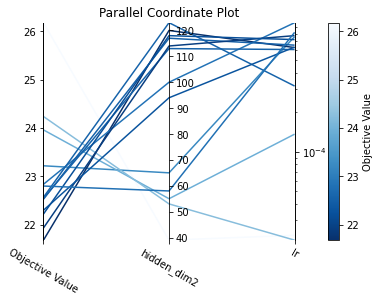

In [24]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_dim2", "lr" ])
optuna.visualization.plot_param_importances(study)

In [25]:
#Download the PT file
from google.colab import files
files.download('LSTMATT_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#Read the pk file
model = LSTMATT(input_dim = 9, 
                hidden_size=120,
                output_dim=24, 
                timesteps=5*24).cuda()

model.load_state_dict(torch.load("LSTMATT_BO.pt"))

<All keys matched successfully>

In [27]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [28]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [30]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   105.09566802570572
R^2                :        0.9792306384132912
Mean Absolute Error:        83.42866149986997
MAPE               :        0.01383101763640534


error for next 2 hour prediction
Root Mean Squared Error :   135.29759188586615
R^2                :        0.9647684811760627
Mean Absolute Error:        106.92335609721741
MAPE               :        0.017530142970505366


error for next 3 hour prediction
Root Mean Squared Error :   142.42510825099896
R^2                :        0.9602652389223159
Mean Absolute Error:        110.38160534143117
MAPE               :        0.01814245794983331


error for next 24 hour prediction
Root Mean Squared Error :   267.62837587163284
R^2                :        0.8453023953170499
Mean Absolute Error:        213.13440737148926
MAPE               :        0.03600590932979061


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


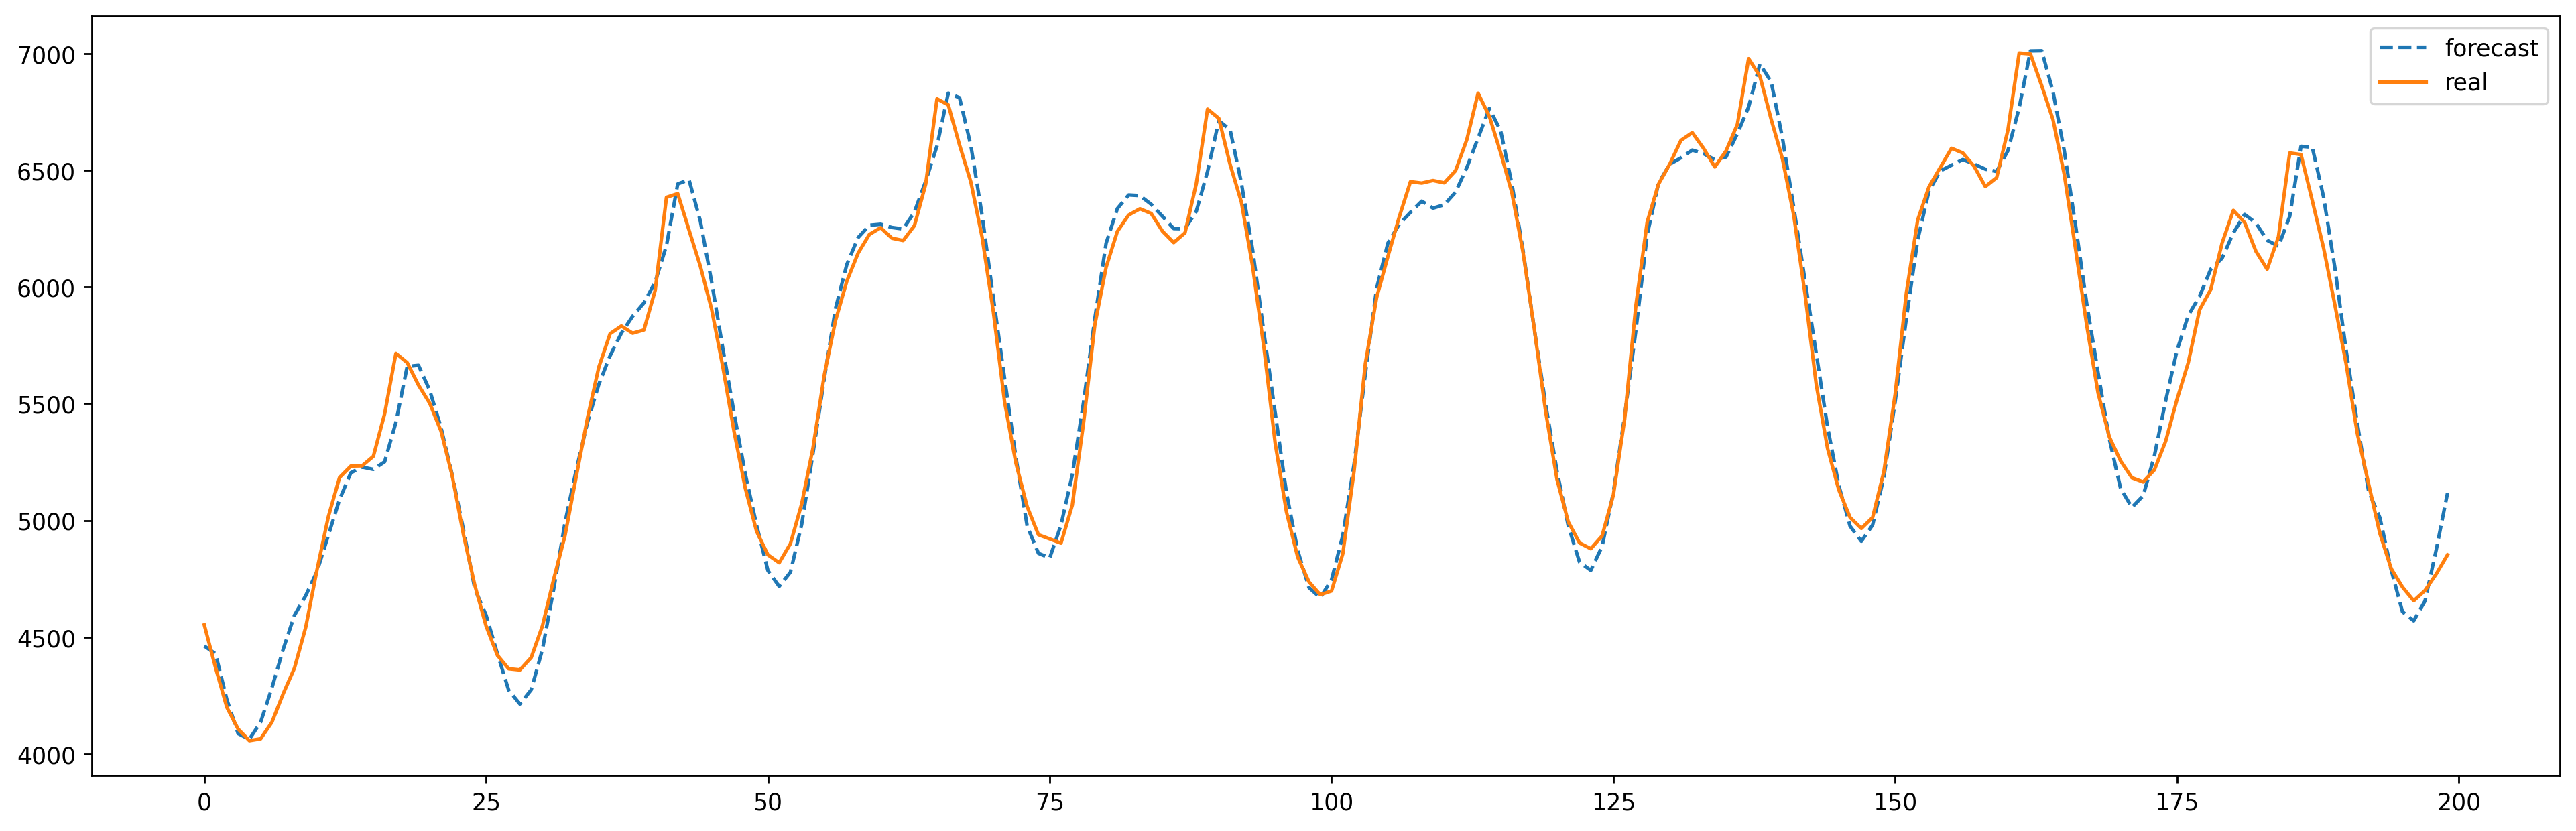

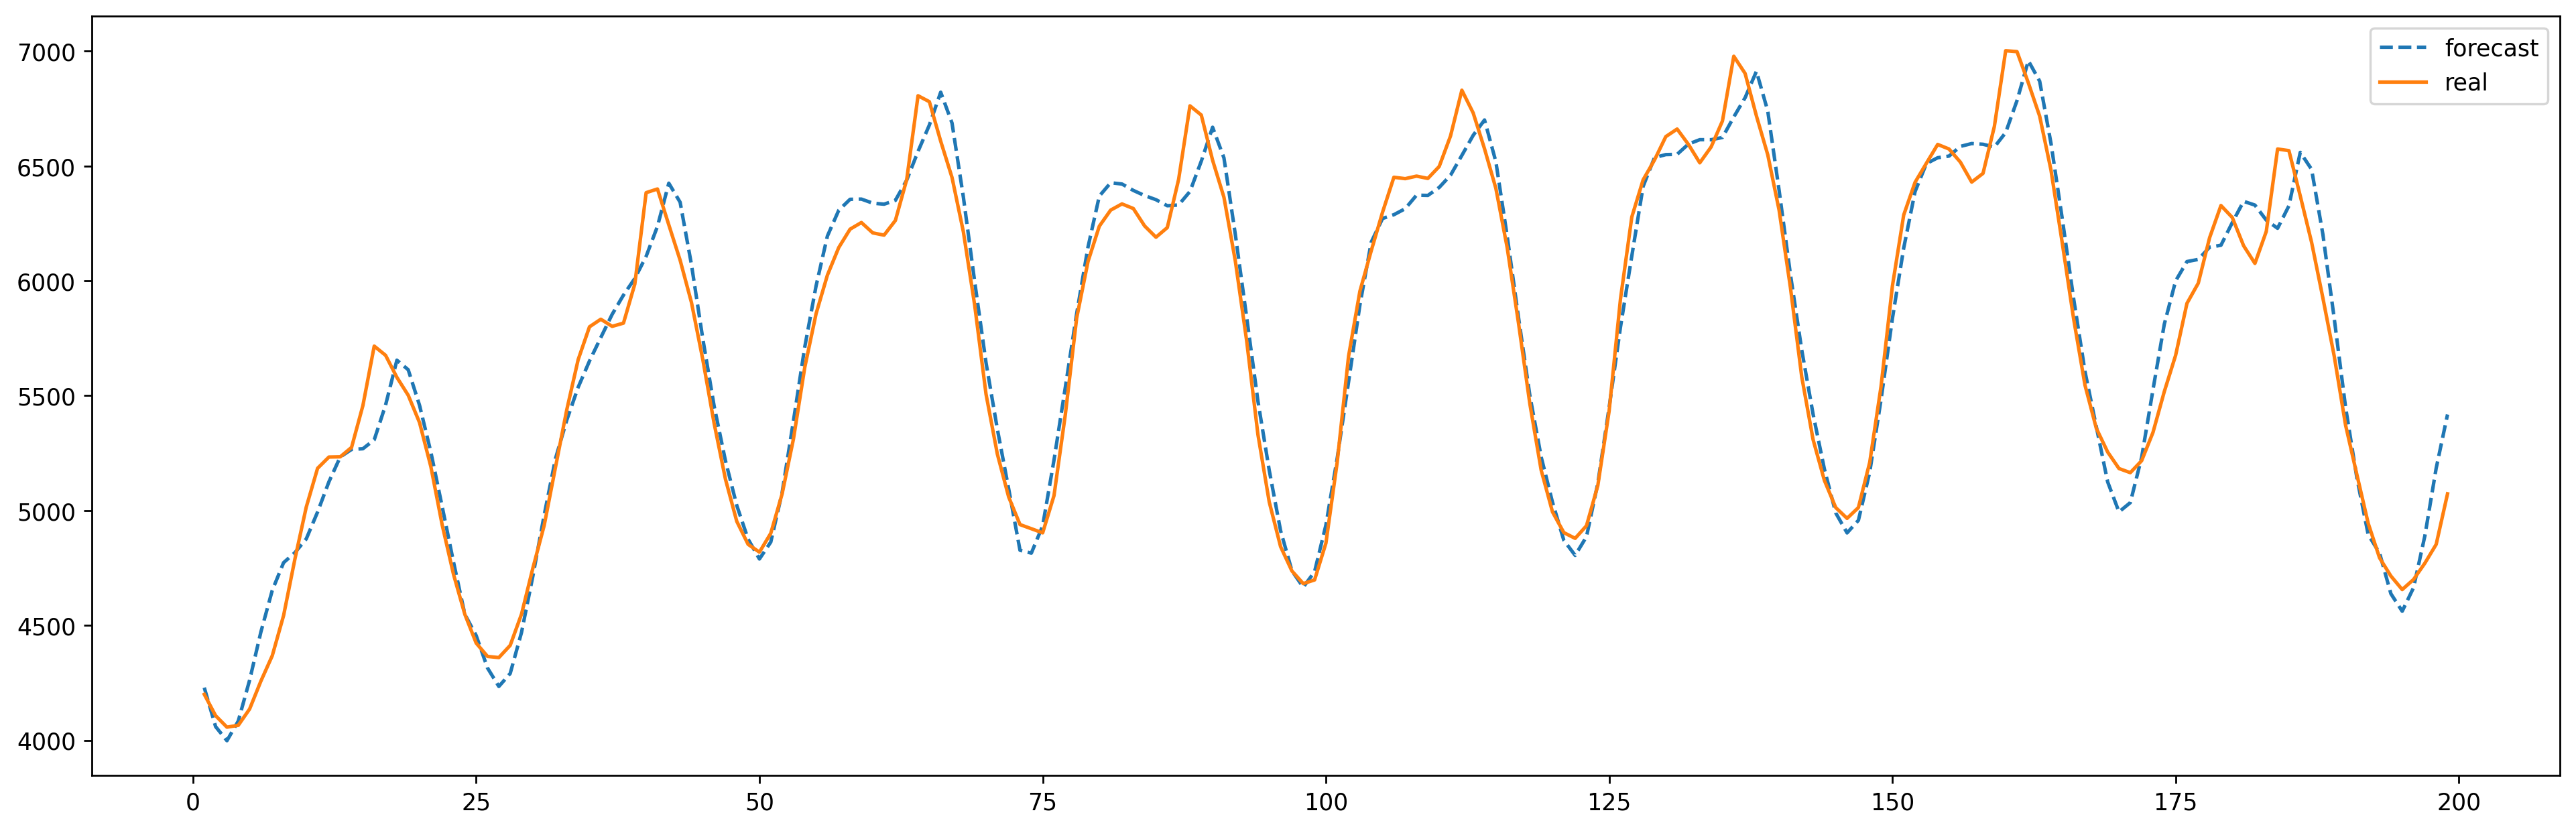

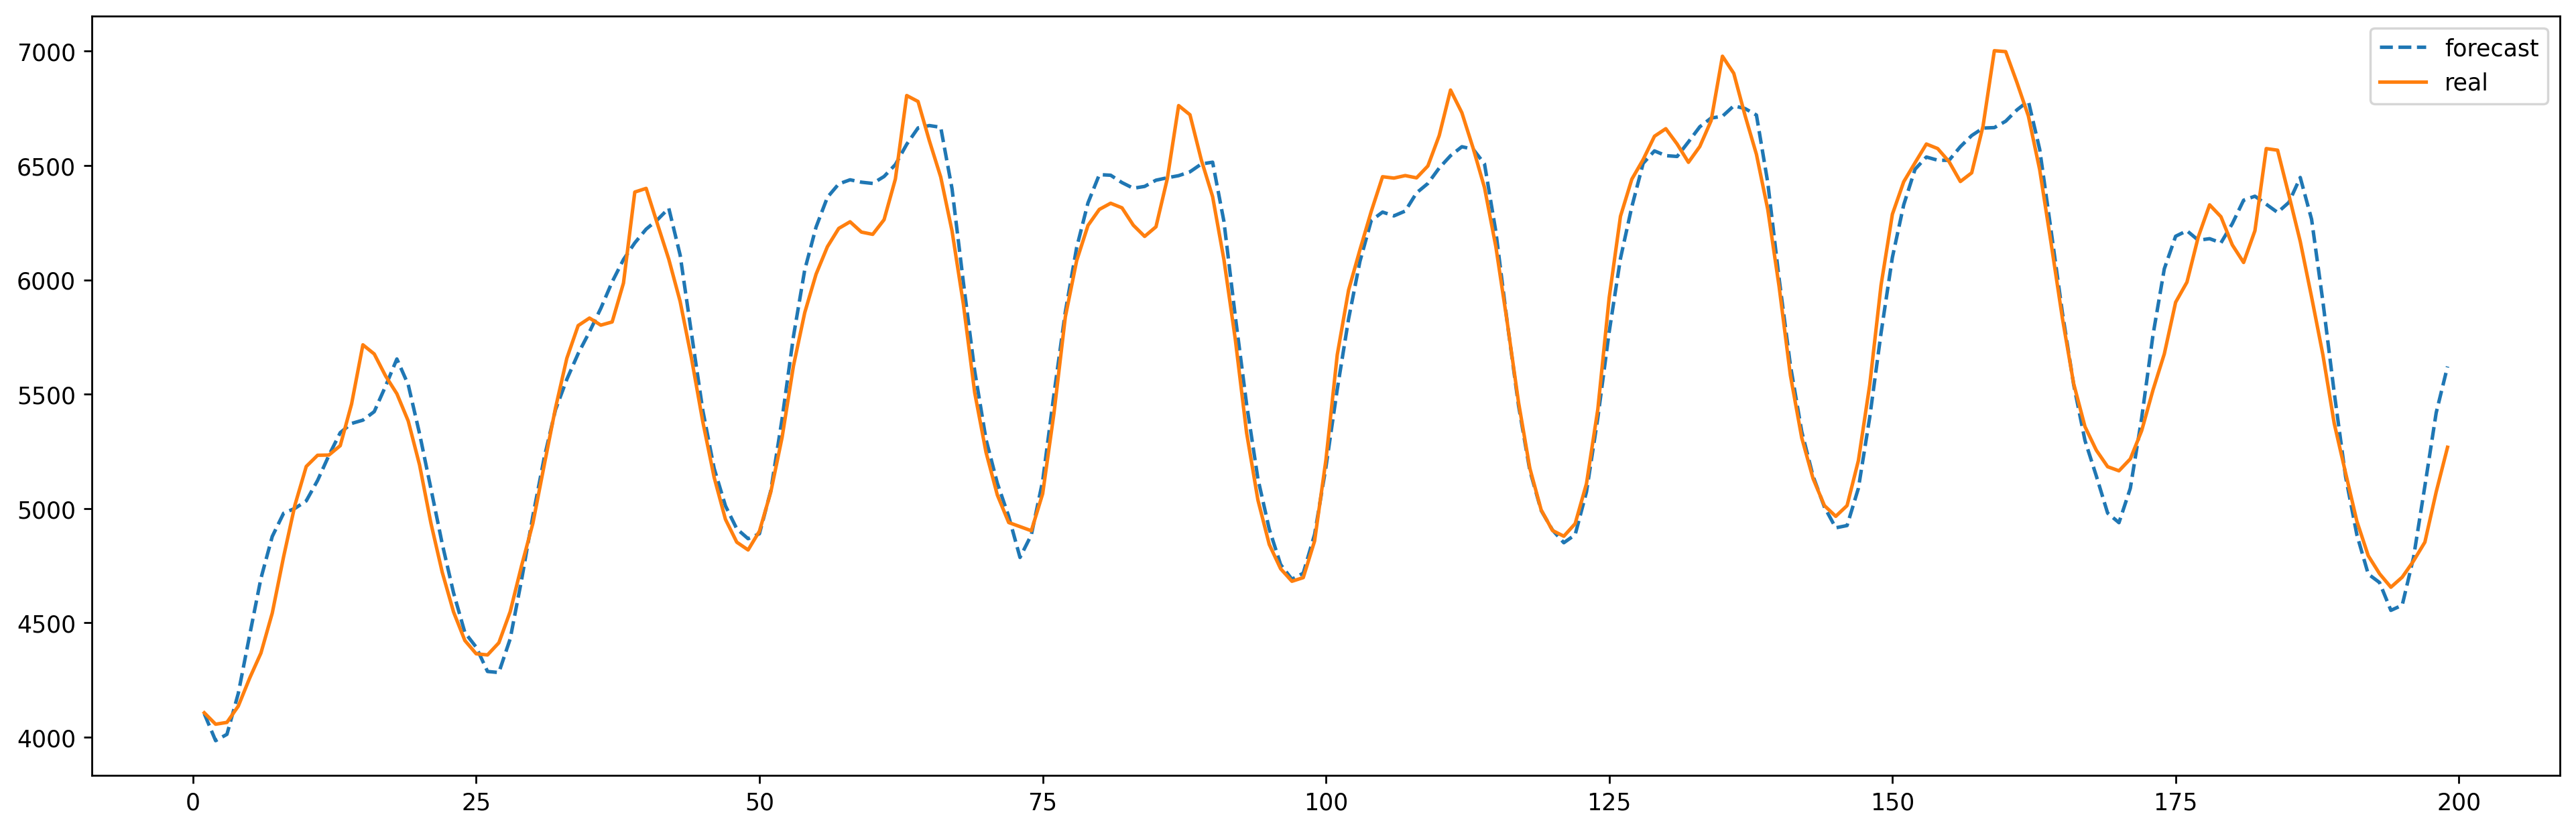

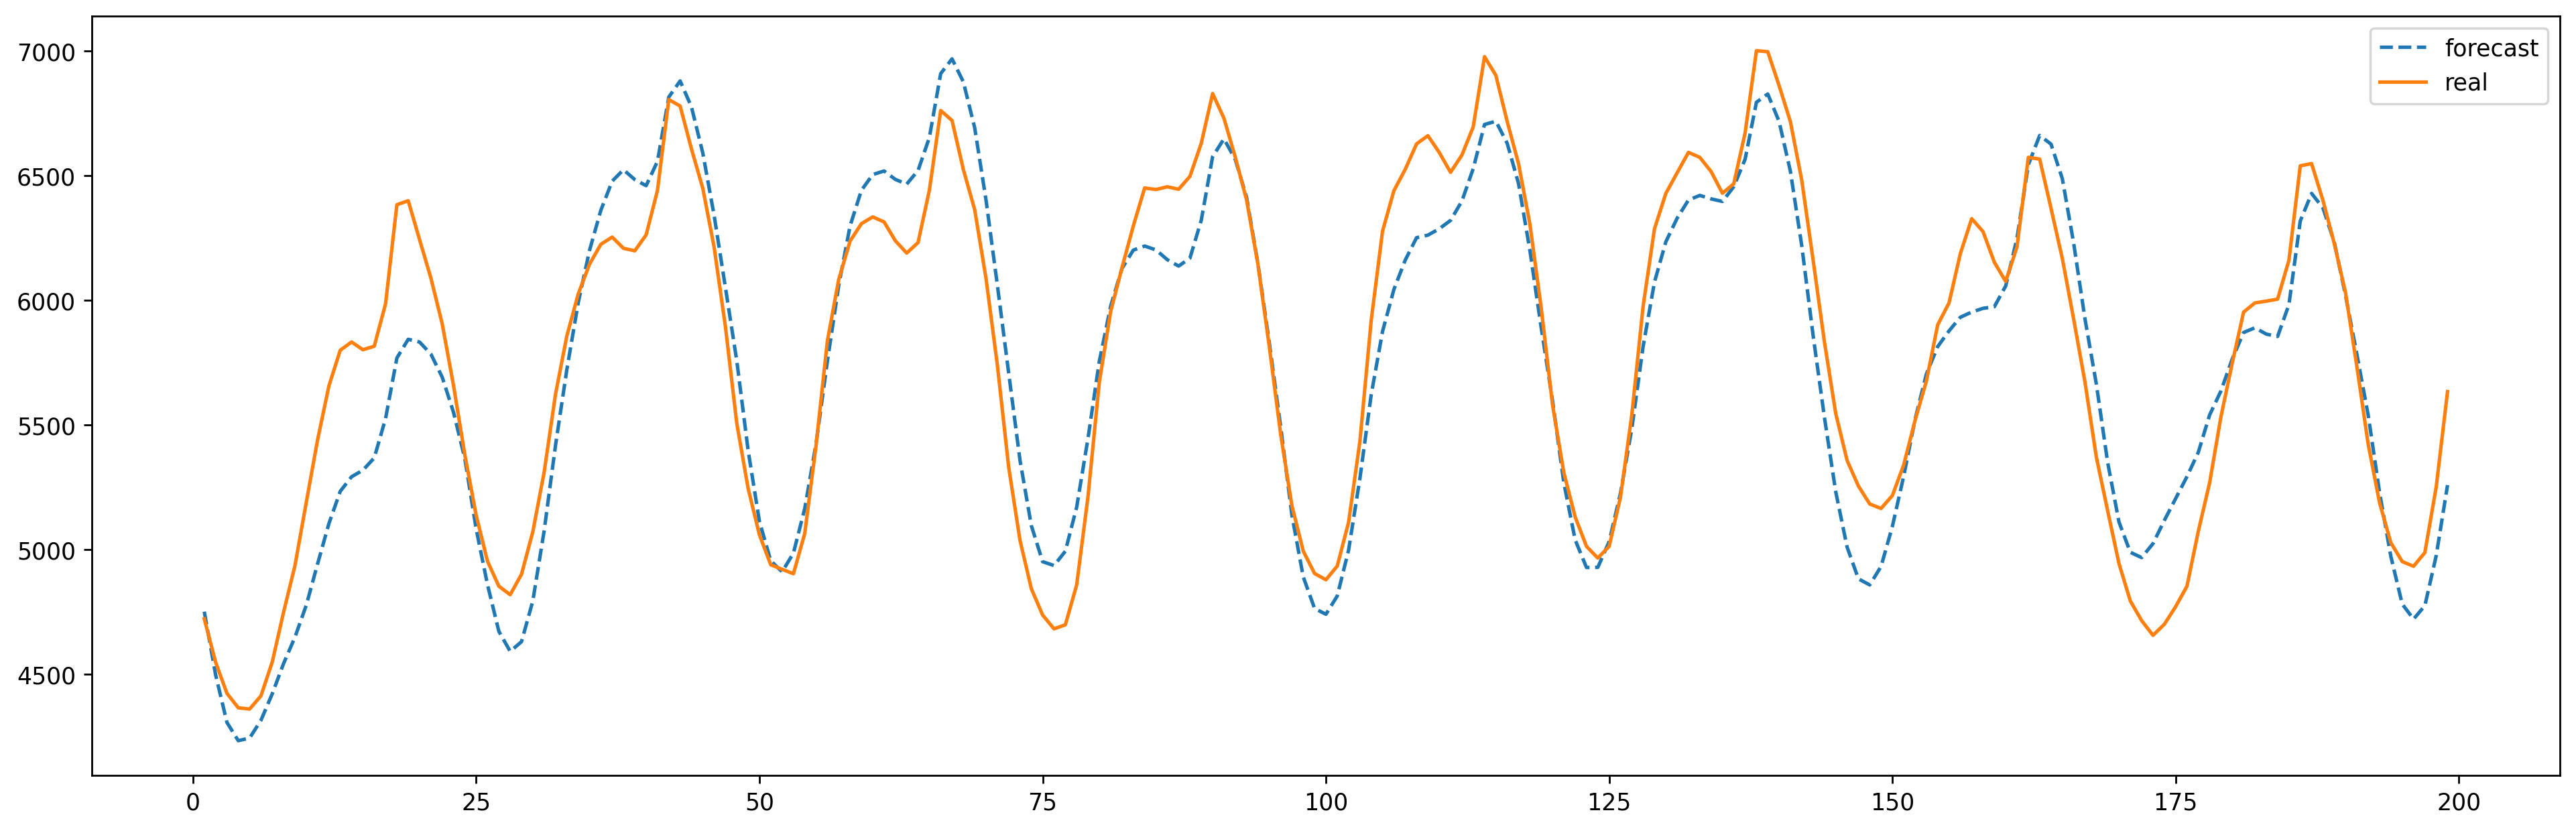

In [31]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [32]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

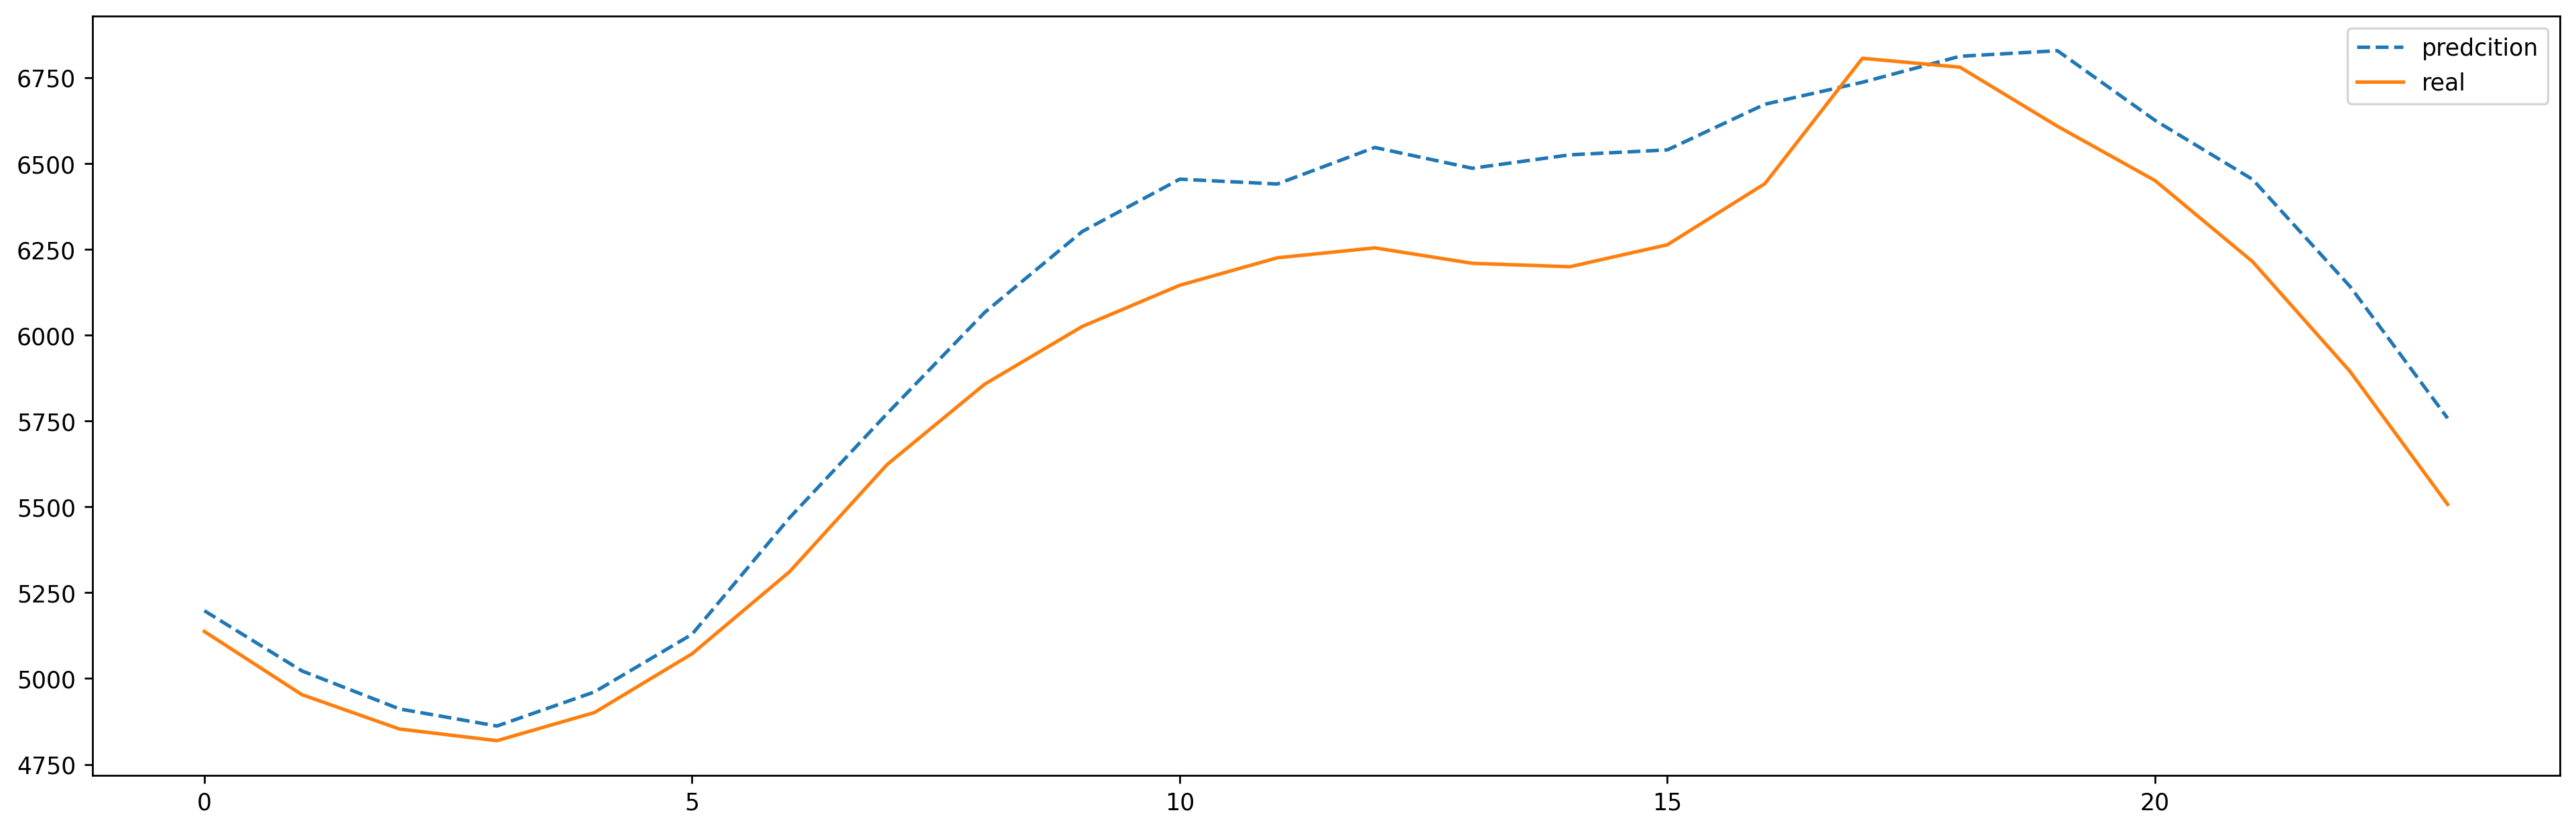

In [35]:
figure(figsize=(19, 6), dpi=250)

j=2*24
dates = range(len(prediction_descaled[j]))
plt.plot(dates[0:24], prediction_descaled[j] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[j], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();
